In [731]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [732]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy


palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


In [733]:
# heatmap parms
heatmap_parms = {
    'cbar': False,
    'square': False,
    'linewidths': 0.5,
    'linecolor': 'black',
    'center': 0.0,
    'vmin': -1,
    'vmax': 1,
    'annot': True,
    'fmt': '.2f',
}



In [734]:
figdir   = "./OUTPUT/lc-pos-figures"
data_dir = "../lc-project-data"

## FUNCTIONS

In [735]:
#===============================================================================
def make_centroids(e, lbls):
#===============================================================================

    # assume that lbls is a pandas series
    if isinstance(lbls, pd.Series):
        lbls = lbls.values
    


    # get the centroids of the umap coordinates by cluster
    centroids = pd.DataFrame(e, 
                                columns = ["x", "y"]).assign(cluster = lbls).groupby("cluster").mean()
    return centroids


#===============================================================================
def make_plot_df(embeddings, clusterer, index, sites):
#===============================================================================

    d = pd.DataFrame(embeddings, columns = ["x", "y"], index = index)
    d["Cluster"]             = clusterer.labels_
    d["Cluster Confidence"]  = clusterer.probabilities_
    d["Most Likely Cluster"] = np.argmax(all_points_membership_vectors(clusterer), axis = 1)
    d["Site"]                = sites


    return d



In [736]:
#===============================================================================
def plot_clusters(df, centroids, title = None, most_likely = True):
#===============================================================================

    # plot the embeddings
    fig, ax = plt.subplots(figsize=(10, 10))

    if most_likely:
        hue = "Most Likely Cluster"
    else:
        hue = "Cluster"

    sns.scatterplot(data = df, 
                    x = "x",
                    y = "y",
                    s = 50,
                    edgecolor = 'black', 
                    hue       = hue,
                    linewidth = 0.5, 
                    palette   = palette_dict,
                    style     = "Site",
                    size      = "Cluster Confidence",
                    ax = ax
                        )

    # plot centroids
    plot_centroids(centroids, ax)

    # set title
    if title:
        plt.title(title)

    # place the legend outside to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off axis labels and ticks
    plt.xticks([]); plt.yticks([]);
    plt.xlabel(""); plt.ylabel("");


#===============================================================================
def plot_centroids(centroids, ax):
#===============================================================================
    # plot the centroids
    for i, centroid in centroids.iterrows():
        if i != -1:

            ax.annotate(
                        i,
                        (centroid.x, centroid.y), 
                        ha='center',
                        va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="white", 
                                    ec="black",
                                    lw=1, 
                                    # alpha=0.75
                                    )
                        )



## LOAD DATA

In [737]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/features.xlsx')

In [738]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# load the dataset from disk
ds_all = Dataset.load_from_disk('../lc-project-data/features.arrow')
ds     = Dataset.load_from_disk('../lc-project-data/features.arrow')
ds83   = Dataset.load_from_disk('../lc-project-data/featuresThresAll83.arrow')
ds81   = Dataset.load_from_disk('../lc-project-data/featuresThresAll81.arrow')
ds

Dataset({
    features: ['sex', 'age', 'dag', 'MED-Analgesics', 'MED-Anesthetics', 'MED-Antibacterials', 'MED-Anticonvulsants', 'MED-Antidepressants\xa0', 'MED-Antifungals', 'MED-Antimigraine-agents', 'MED-Antiparasitics', 'MED-Antiparkinson-agents', 'MED-Antipsychotics', 'MED-Antispasticity-agents', 'MED-Antivirals', 'MED-Blood-glucose-regulators', 'MED-Blood-products', 'MED-Cardiovascular-agents', 'MED-Dermatological-agents', 'MED-Gastrointestinal-agents', 'MED-Hormonal-agents-(adrenal)', 'MED-Hormonal-agents-(sex-hormones)', 'MED-Hormonal-agents-(thyroid)', 'MED-Hormone-suppressant-(thyroid)', 'MED-Immunological-agents', 'MED-Inflammatory-bowel-disease-agents', 'MED-Metabolic-bone-disease-agents', 'MED-Ophthalmic-agents', 'MED-Respiratory-tract-agents', 'MED-Skeletal-muscle-relaxants', 'SYMPT-abdominal_pain___1', 'SYMPT-abdominal_pain___2', 'SYMPT-chest_pain___1', 'SYMPT-chest_pain___2', 'SYMPT-confusion_altered_mental_s___1', 'SYMPT-confusion_altered_mental_s___2', 'SYMPT-cough___1

In [739]:
df_all = ds_all.data.to_pandas()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 420 entries, sex to LC_STATUS
dtypes: float64(366), int64(53), object(1)
memory usage: 18.6+ MB


In [740]:
# convert to pandas dataframe
df = ds.to_pandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Columns: 420 entries, sex to LC_STATUS
dtypes: float64(366), int64(53), object(1)
memory usage: 18.6+ MB


In [741]:
feature_81_list = ds81.features
feature_83_list = ds83.features
feature_all_list = ds_all.features

df_all = ds_all.data.to_pandas()
df81   = ds81.data.to_pandas()
df83   = ds83.data.to_pandas()
df     = ds.data.to_pandas()

## LC+, LC-, HC

In [742]:
# get a list of features in df
# fdf_list = df.columns.tolist()
# fdf_list

### Select which sets of feaetures to use

In [808]:
tag = 'all'

if tag == 'all':
    df = df_all
elif tag == '81':
    df = df81
elif tag == '83':
    df = df83


# df = deepcopy(df83)
print(df.shape)

(5802, 420)


In [809]:
LC_pos = df.query('LC_STATUS == "LC_POS"')
LC_neg = df.query('LC_STATUS == "LC_NEG"')
HC = df.query('LC_STATUS == "HC"')


In [810]:
LC_pos.shape, LC_neg.shape, HC.shape

((2461, 420), (3260, 420), (81, 420))

In [811]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass


## SITES

In [812]:
site_name_dict = {1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                    4: 'RIO',
                    5: 'LUS',
}

In [813]:
# map dag using site_name_dict
LC_pos['SITE'] = LC_pos['dag'].map(site_name_dict)

In [814]:
# get the range of indices for each site
site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

SITE
MTL       (0, 1764)
RIO    (2913, 3571)
LUS    (3709, 5146)
SAN    (5180, 5406)
LDN    (5500, 5801)
dtype: object

In [815]:
# drop RIO and LUS
# LC_pos = LC_pos.query('SITE != "RIO" and SITE != "LUS"')
# LC_pos = LC_pos.query(' SITE != "LUS"')
LC_pos['SITE'].value_counts()

SITE
MTL    916
RIO    659
LUS    549
SAN    227
LDN    110
Name: count, dtype: int64

In [816]:
# get the range of indices for each site
site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

site_ranges.sort_values()

SITE
MTL       (0, 1764)
RIO    (2913, 3571)
LUS    (3709, 5146)
SAN    (5180, 5406)
LDN    (5500, 5801)
dtype: object

# CLUSTERING

In [817]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [818]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos

# drop certain columns, to experiment with effect on clustering
# # based on experiments, MED and CD do almost nothing for clustering, so we drop them
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT').columns)

print(LC_pos_.shape)

(2461, 420)


In [819]:
the_list = LC_pos_.columns.tolist()

In [820]:
d2 = set(feature_83_list) - set(cluster_features)

# output to a json file
import json

# convert the set to a list
d2 = list(d2)

# sort the list
d2.sort()

with open('./OUTPUT/cluster_feature_SUBTRACTED.json', 'w') as f:
    json.dump(d2, f, indent = 4)


In [821]:
# which columns are in the clustering features but are absent from the feature_83_list?

delta_features = set(cluster_features) - set(feature_83_list)

# output to a json file
import json

# convert the set to a list
delta_features = list(delta_features)

# sort the list
delta_features.sort()

with open('./OUTPUT/cluster_feature_ADDED.json', 'w') as f:
    json.dump(delta_features, f, indent = 4)


In [822]:
len(feature_81_list), len(feature_83_list), len(cluster_features)

(108, 87, 115)

In [823]:
# fdf_list = LC_pos_.columns.tolist()
# fdf_list
# len(fdf_list), len(f81_list)
# what is the difference between fdf_list and f81_list
# set(fdf_list) - set(f81_list)



In [824]:
# # EXPERIMENTAL

# # drop HC from the df
# EXPT = df.query('LC_STATUS != "HC"')

# # convert LC_STATUS to a binary variable in the entire dataframe
# EXPT["LC_STATUS"] = EXPT["LC_STATUS"].map({"LC_POS": 1, "LC_NEG": 0, "HC": 0})

# EXPT

In [825]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

try:
    X = scaler.fit_transform(LC_pos_.drop(columns=['dag', 'SITE', "__index_level_0__"])) 
except:
    X = scaler.fit_transform(LC_pos_.drop(columns=['dag', 'SITE']))    

# # EXPERIMENTAL
# try:
#     X = scaler.fit_transform(EXPT.drop(columns=['dag', 'SITE']))    
# except:
#     X = scaler.fit_transform(EXPT)



### Handling missing values

In [826]:

# the clustering algorithms depend on the data being complete
# if we drop NAs, then there are only 3 records from LUS left
# X = X.dropna()

# if we fill with zeroes, then we are assuming that the missing values are zero
X.fillna(0, inplace = True)

# a reference copy of the data, for later use in other clustering algorithms
X_ref = deepcopy(X)
print(X.shape, X_ref.shape)



(2461, 418) (2461, 418)


In [827]:
# X = X.drop(columns = X.filter(regex = 'LABS').columns)
# X = X.drop(columns = X.filter(regex = 'CD').columns)
# X = X.drop(columns = X.filter(regex = 'MED').columns)
# X = X.drop(columns = X.filter(regex = 'dag').columns)
# X = X.drop(columns = X.filter(regex = 'LC_STATUS').columns)
# print(X.shape), print(X.index)

## Use UMAP to visualize the data and cluster

In [828]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

hdb_parms = {
                # min_cluster_size is rouglhy 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': 50, 
                'min_samples': 10,
                'prediction_data': True,
                'cluster_selection_method': 'leaf',
                # epsilon
                'cluster_selection_epsilon': 0.5,


            }


umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
            }


# instantiate the clustering and dim reduction objects
hdb_umap   = HDBSCAN(**hdb_parms)
umap_      = UMAP(**umap_parms)

In [829]:
# always use the reference data for clustering
X = deepcopy(X_ref)

# dimension reduction
umap_embeddings = umap_.fit_transform(X)

# clustering on the reduced data
hdb_umap.fit(umap_embeddings)
# get the cluster vectors
cvec = all_points_membership_vectors(hdb_umap)
# cluster labels are the maximally probable cluster
cluster_labels = np.argmax(cvec, axis = 1)

print(f"Found {len(np.unique(cluster_labels))} clusters")

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1393: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Found 14 clusters


In [830]:
# # select all points with x < -20
# ddd.query('x < -20')

# idx = ddd.query('x < -20').index

# # look up these indices in the original dataframe
# df_all.loc[idx].sum(axis = 0)

# # how many are zeros?
# df_all.loc[idx].sum(axis = 0).value_counts()


In [831]:
# # make a plotting dataframe
sites = LC_pos_["dag"].map(site_name_dict)
plot_df = make_plot_df(umap_embeddings, hdb_umap, X_ref.index, sites)

# get the centroids of the umap coordinates by cluster
umap_centroids = make_centroids(umap_embeddings, cluster_labels)

In [832]:
# # make a list of colours, desaturated by the probability of the cluster
plot_df["colour"] = plot_df["Cluster"].map(palette_dict)
plot_df["colour"] = plot_df["colour"].apply(lambda x: mc.to_rgba(x, alpha = 0.5))

<Axes: xlabel='x', ylabel='y'>

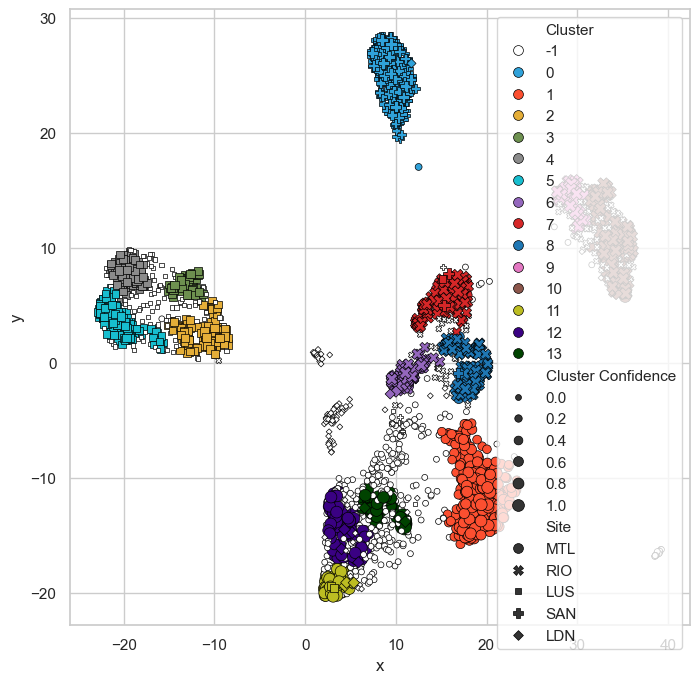

In [833]:
sns.scatterplot(data = plot_df, 
                x = "x",
                y = "y",
                s = 50,
                edgecolor = 'black', 
                hue       = "Cluster",
                linewidth = 0.5, 
                palette   = palette_dict,
                style     = "Site",
                size      = "Cluster Confidence"
                    )

In [834]:
X.shape

(2461, 418)

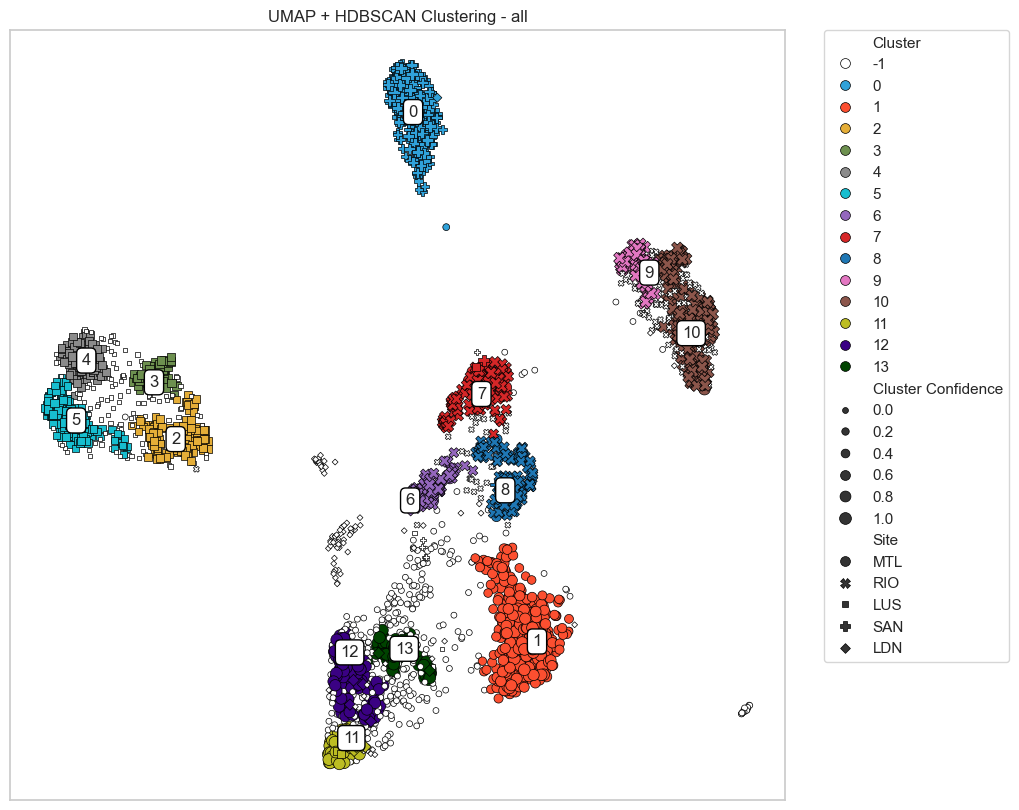

In [835]:
plot_clusters(plot_df, umap_centroids, title = f"UMAP + HDBSCAN Clustering - {tag}", most_likely = False)

fn = f"clusters-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

In [836]:
# # another way - cluster first in high-dim space, then reduce to 2D

# # cluster
# hdb_.fit(X)

# # get the cluster vectors
# cvec = all_points_membership_vectors(hdb_)

# # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(cvec, axis = 1)
# # umap
# X_umap = umap_.fit_transform(X, y = cluster_labels)
# # X_umap = umap_.fit_transform(X, )
# # X_umap = umap_.fit_transform(X, y = LC_pos["dag"])

# dplot2 = pd.DataFrame(X_umap, columns = ["x", "y"], index = X.index)
# dplot2["cluster"] = cluster_labels
# dplot2["Site"] = LC_pos_["dag"].map(site_name_dict)

# # plot the clusters
# fig, ax = plt.subplots(figsize=(10, 10))
# sns.scatterplot(data = dplot2, x="x", y = "y", hue="cluster", s=50, palette = palette,  edgecolor='black', linewidth=0.5, ax = ax, style = "Site",)
# # make marker size larger
# plt.legend(markerscale=1)

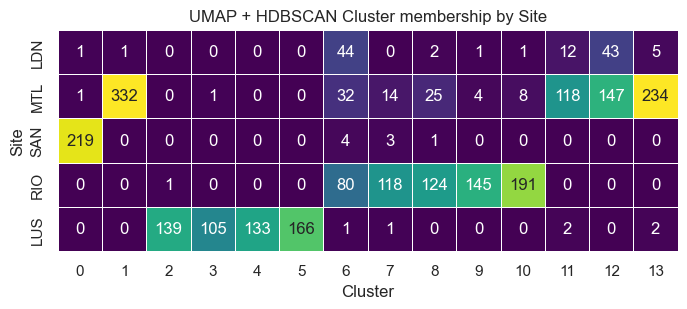

In [837]:
# augment the LCPOS with the cluster labels
LC_pos_.loc[X.index, "cluster"] = plot_df["Most Likely Cluster"]

cluster_by_site = LC_pos_.groupby("cluster")["SITE"].value_counts().unstack().T
cluster_by_site = cluster_by_site.fillna(0).astype(int)
cluster_by_site.columns = cluster_by_site.columns.astype(int)
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]


fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cluster_by_site, robust = True, ax = ax, annot = True, fmt = "d", cmap = "viridis", square = True, linewidths = 0.5, linecolor = "w", cbar = False)

# rename axis labels
plt.xlabel("Cluster")
plt.ylabel("Site")


plt.title("UMAP + HDBSCAN Cluster membership by Site")

fn = f"cluster-membership-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


### Examine some of the clusters

In [838]:
# save the cluster labels to the original dataframe
# we add the cluster labels here, which is way the clusterers should always be fed X_ref (a clean, reference copy of the original dataframe)


X["cluster"] = cluster_labels

interesting = ["sex", "HHX-HIV or AIDS", "VAX-vaccinated"]

try:
    # get the means by cluster
    X.groupby("cluster")[interesting].mean()
except:
    pass


In [839]:
# # how many HIV or AIDS in each cluster?
# X.groupby("cluster")["HHX-HIV or AIDS"].value_counts(normalize = False).unstack().fillna(0)

In [840]:
# # how many HIV or AIDS in the original dataset?
# LC_pos["HHX-HIV or AIDS"].value_counts(normalize = False)

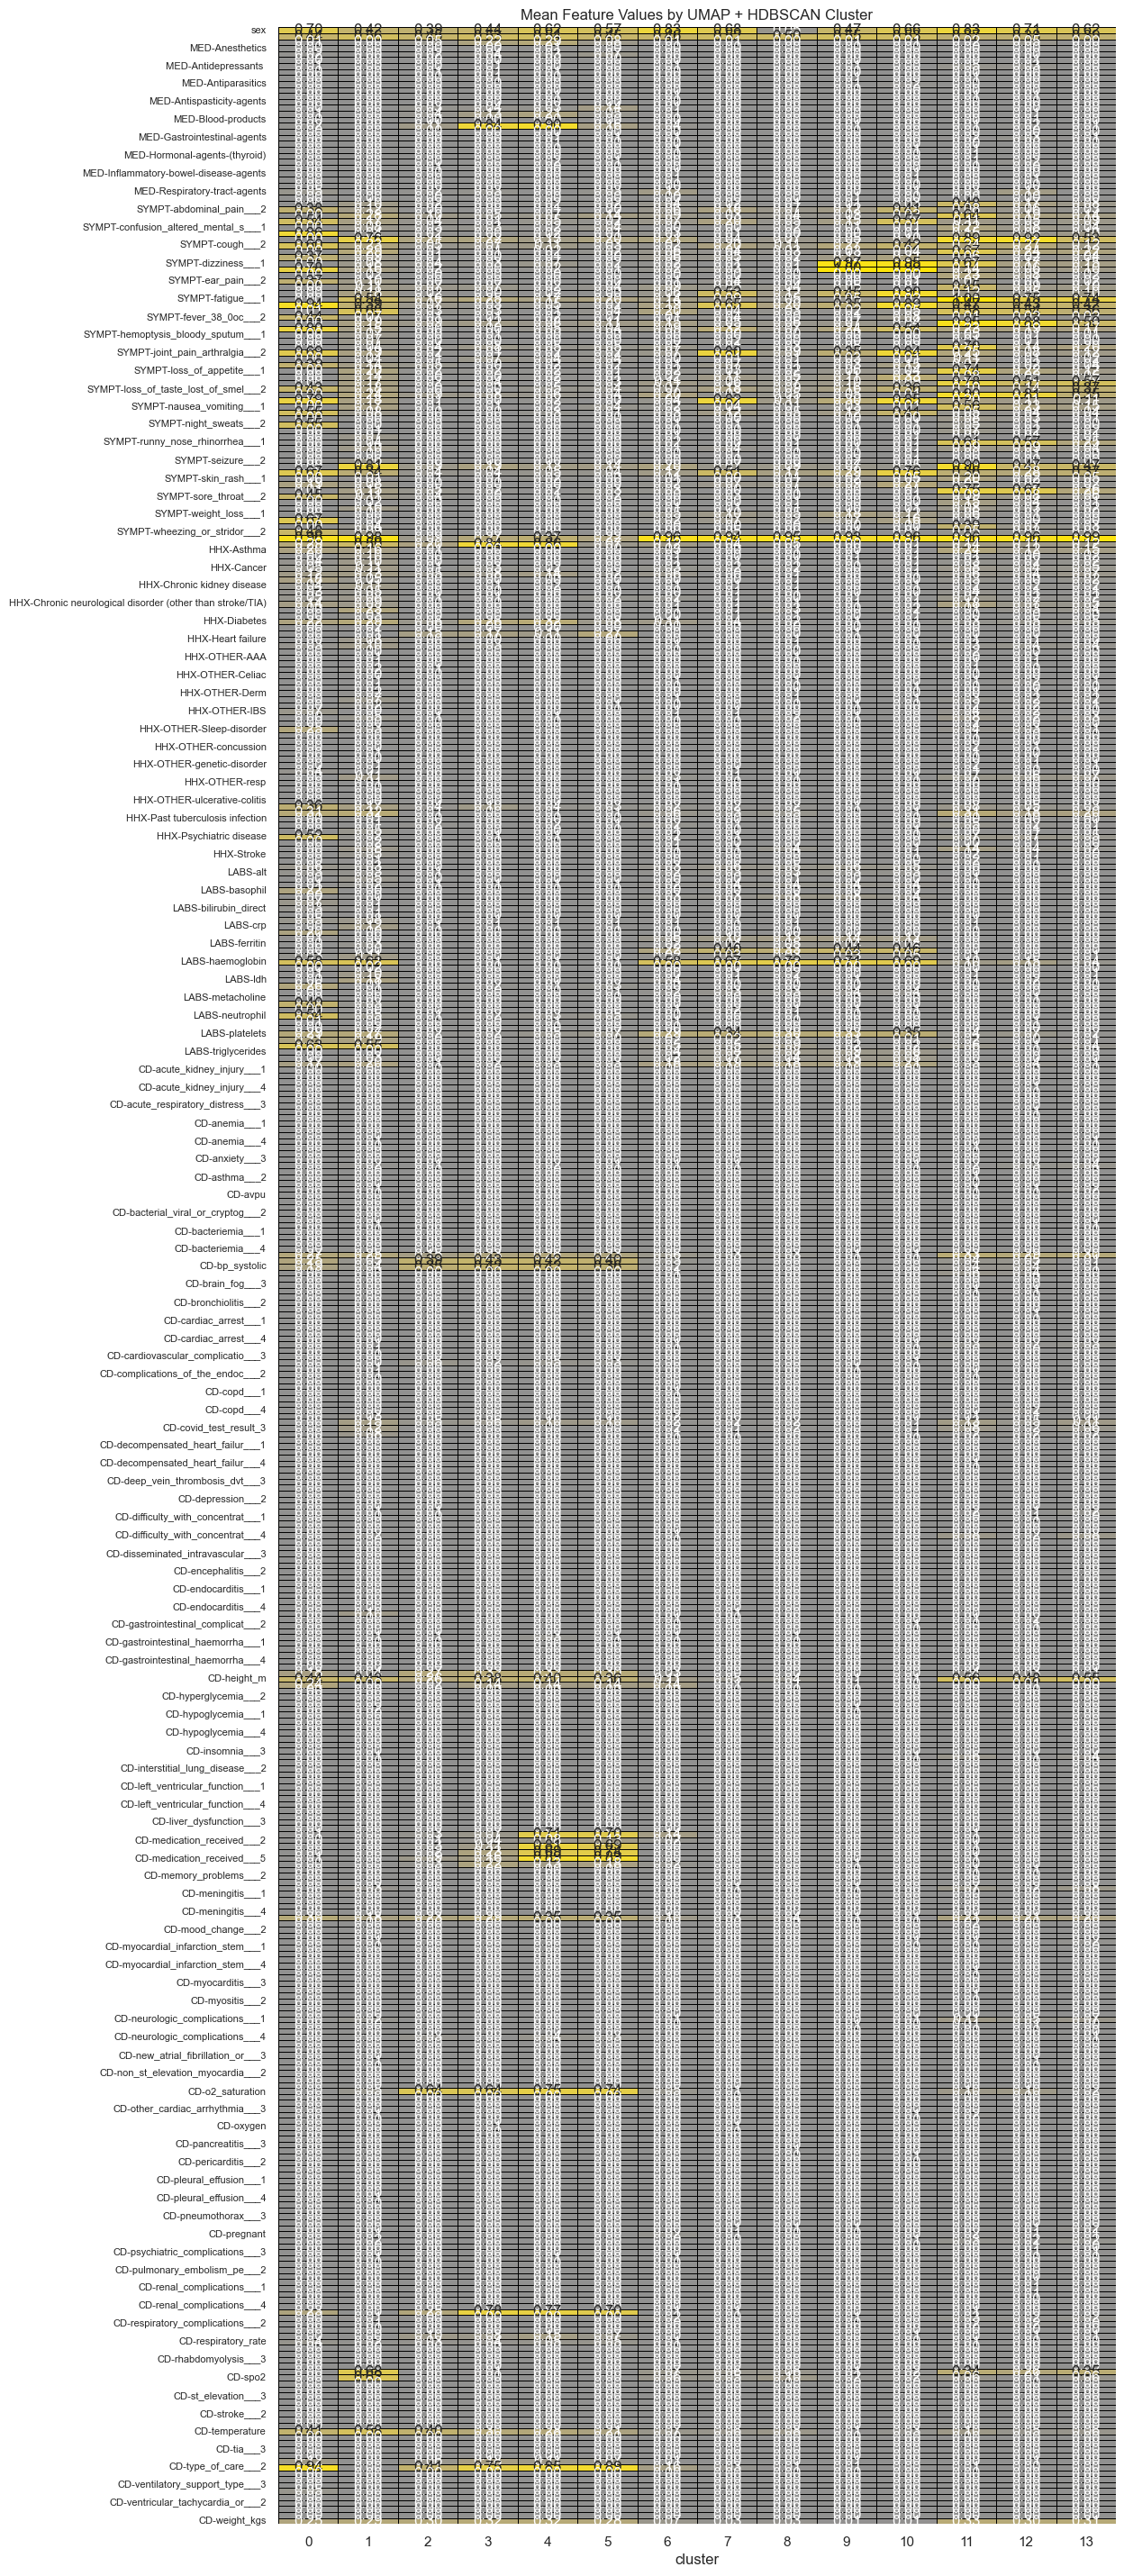

In [841]:
# heatmap of the means by cluster
fig, ax = plt.subplots(figsize=(12,36))

# apply lognorm to the colour scale
norm = mc.LogNorm(vmin = 0.01, vmax = 10.0)
norm = None

# get the means by cluster

mm = X.groupby("cluster").mean().T

# negative log transform
# mm = -np.log10(mm)

# sort mm in alphabetical order
# mm = mm.sort_index()

# use a diverging colour scheme
cmap = sns.diverging_palette(220, 20, as_cmap = True)

cmap = cc.cm.bjy

sns.heatmap(mm, cmap = cmap, ax = ax, **heatmap_parms, norm = norm)

plt.title("Mean Feature Values by UMAP + HDBSCAN Cluster")
# make font smaller
plt.yticks(fontsize = 8);


fn = f"mean-feature-values-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

In [842]:
# # group by cluster and count the number of records
# cluster_counts = X.groupby("cluster")

# # pivot table for counts of specific symptoms
# symptom_counts = X.groupby("cluster").sum()/cluster_counts.count()*100
# symptom_counts[["HHX-HIV or AIDS", "VAX-vaccinated"]]

In [843]:
# # group LC_pos by site and get Psychiatric disease counts
# LC_pos.groupby("SITE")["HHX-Psychiatric disease"].value_counts().unstack().fillna(0)


In [844]:
# sns.clustermap(X.drop(["cluster"], axis = 1), row_cluster = False, col_cluster = True, cmap = "viridis")

## Use IVIS to visualize the data and cluster

In [845]:
# # load ivis module
# from ivis import Ivis

# XX_ivis = deepcopy(np.array(X_ref))

# ivis = Ivis(k = 150, verbose = 0)
# ivis.fit(XX_ivis)
# ivis_embeddings = ivis.transform(XX_ivis)

# hdb_ivis = HDBSCAN(**hdb_parms)
# hdb_ivis.fit(ivis_embeddings)

In [846]:
# sites = LC_pos_["dag"].map(site_name_dict)
# ivis_df        = make_plot_df(ivis_embeddings, hdb_ivis, X_ref.index, sites)
# ivis_centroids = make_centroids(ivis_embeddings, ivis_df["Most Likely Cluster"])


In [847]:
# plot_clusters(ivis_df, ivis_centroids, title = "IVIS + HDBSCAN Clustering")

# fn = "clusters-ivis.png"
# p = f"{figdir}/{fn}"

# plt.savefig(p, dpi = 300, bbox_inches = 'tight')


In [848]:
# cluster_labels = ivis_df["Most Likely Cluster"]

# LC_pos_.loc[X_ref.index, "cluster"] = cluster_labels

# cluster_by_site = LC_pos_.groupby("cluster")["SITE"].value_counts().unstack().T
# cluster_by_site = cluster_by_site.fillna(0).astype(int)
# cluster_by_site.columns = cluster_by_site.columns.astype(int)
# cluster_by_site = cluster_by_site.loc[site_name_dict.values()]



# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(cluster_by_site, 
#                     robust = True, 
#                     ax = ax, 
#                     annot = True, 
#                     fmt = "d", 
#                     cmap = "viridis", 
#                     square = True, 
#                     linewidths = 0.5, 
#                     linecolor = "w", 
#                     cbar = False
#                     )

# # rename axis labels
# plt.xlabel("Cluster")
# plt.ylabel("Site")

# plt.title("IVIS + HDBSCAN Cluster membership by Site")

# fn = "cluster-membership-ivis.png"
# p = f"{figdir}/{fn}"

# plt.savefig(p, dpi = 300, bbox_inches = 'tight')


In [849]:
# # sort cluster by site by site, using the ordering as site_name_dict
# cluster_by_site = cluster_by_site.loc[site_name_dict.values()]
# cluster_by_site

In [850]:
# # heatmap of the means by cluster
# fig, ax = plt.subplots(figsize=(12,36))

# # apply lognorm to the colour scale
# norm = mc.LogNorm(vmin = 0.01, vmax = 10.0)
# norm = None

# # get the means by cluster

# XX = deepcopy(X_ref)

# # augment with cluster
# XX["cluster"] = ivis_df["Most Likely Cluster"]

# mm = XX.groupby("cluster").mean().T

# # negative log transform
# # mm = -np.log10(mm)

# # sort mm in alphabetical order
# # mm = mm.sort_index()

# # use a diverging colour scheme
# cmap = sns.diverging_palette(220, 20, as_cmap = True)

# cmap = cc.cm.bjy

# sns.heatmap(mm, cmap = cmap, norm = norm, **heatmap_parms, ax = ax)

# plt.title("Mean Feature Values by IVIS + HDBSCAN Cluster")
# # make font smaller
# plt.yticks(fontsize = 8);
# # plt.savefig('mean_feature_values.png', dpi = 300)

# fn = "mean-feature-values-ivis.png"
# p = f"{figdir}/{fn}"

# plt.savefig(p, dpi = 300, bbox_inches = 'tight')


## Use TSNE to visualize the data and cluster

In [851]:
# import TSNE from sklearn
from sklearn.manifold import TSNE

XX = deepcopy(X_ref)

tsne = TSNE(n_components = 2, perplexity = 30, random_state = 42)
tsne_embeddings = tsne.fit_transform(XX)
hdb_tsne = HDBSCAN(**hdb_parms)
hdb_tsne.fit(tsne_embeddings)


HDBSCAN(cluster_selection_epsilon=0.5, cluster_selection_method='leaf',
        min_cluster_size=50, min_samples=10, prediction_data=True)

In [852]:
# data frame and centroids for plotting
sites = LC_pos_["dag"].map(site_name_dict)
tsne_df        = make_plot_df(tsne_embeddings, hdb_tsne, X_ref.index, sites)
tsne_centroids = make_centroids(tsne_embeddings, tsne_df["Most Likely Cluster"])


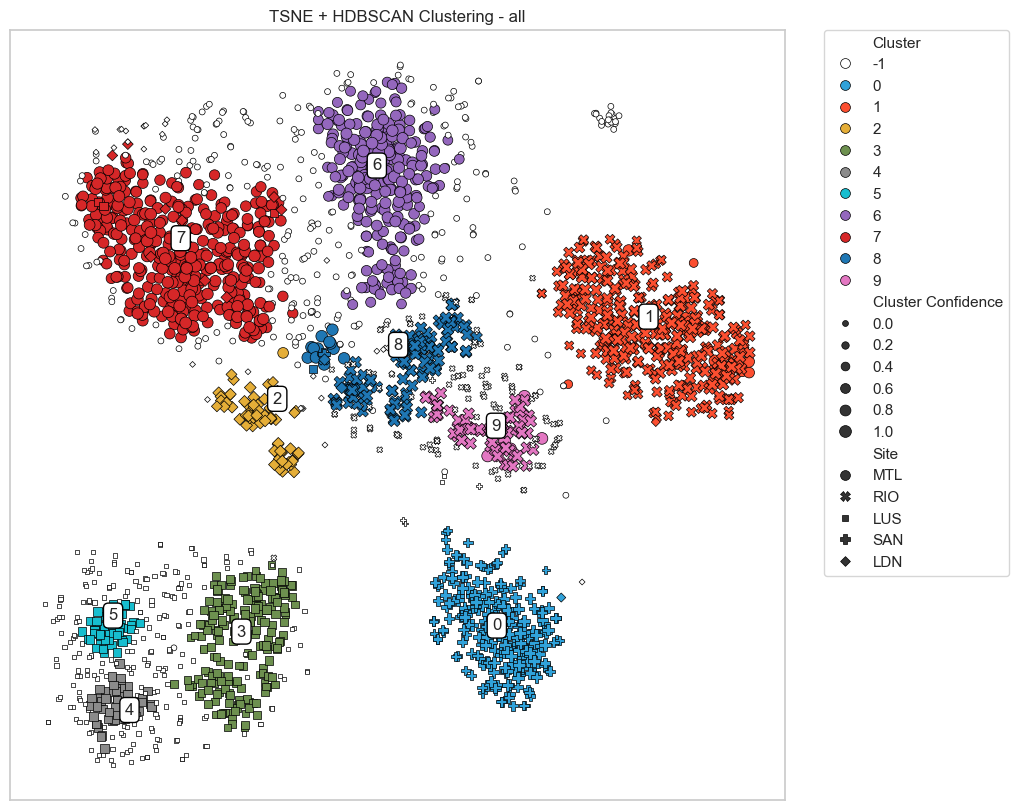

In [853]:
plot_clusters(tsne_df, tsne_centroids, title = f"TSNE + HDBSCAN Clustering - {tag}", most_likely = False)

fn = f"clusters-tsne-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


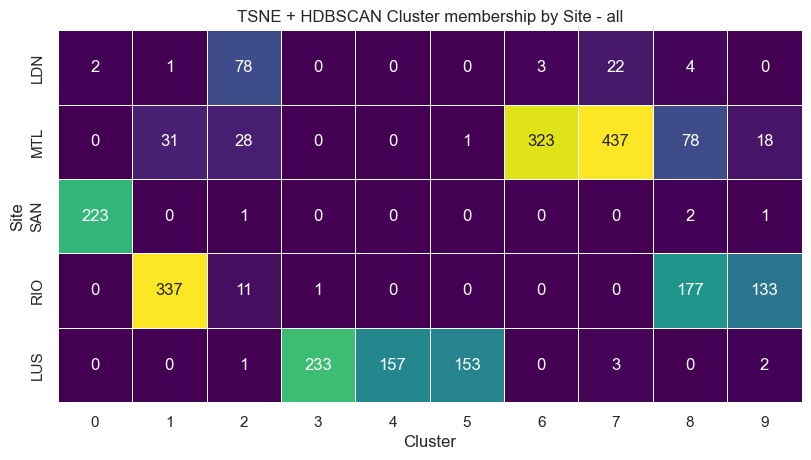

In [854]:
# augment the LCPOS with the cluster labels

cluster_labels = tsne_df["Most Likely Cluster"]

LC_pos_.loc[X.index, "cluster"] = cluster_labels

cluster_by_site = LC_pos_.groupby("cluster")["SITE"].value_counts().unstack().T
cluster_by_site = cluster_by_site.fillna(0).astype(int)
cluster_by_site.columns = cluster_by_site.columns.astype(int)
cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

fig, ax = plt.subplots(figsize=(8,8), layout = "constrained")

sns.heatmap(cluster_by_site, 
                    robust = True, 
                    ax = ax, 
                    annot = True, 
                    fmt = "d", 
                    cmap = "viridis", 
                    square = True, 
                    linewidths = 0.5, 
                    linecolor = "w", 
                    cbar = False
                    )

# rename axis labels
plt.xlabel("Cluster")
plt.ylabel("Site")

plt.title(f"TSNE + HDBSCAN Cluster membership by Site - {tag}")

fn = f"cluster-membership-tsne-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')    

In [855]:
# which LC_pos records are in clusster 4?
c4 = LC_pos_.query("cluster == 3")
c5 = LC_pos_.query("cluster == 9")

# use the __indec_level_0__ to get the original index
c4.index = c4.index
c5.index = c5.index
# # use the __indec_level_0__ to get the original index
# c4.index = c4["__index_level_0__"].rename("index")
# c5.index = c5["__index_level_0__"].rename("index")


In [856]:
# use c4 index and c5 index to get rows from the df_all dataset
c4_all = df_all.loc[c4.index]
c5_all = df_all.loc[c5.index]

# stack them
c4_all["cluster"] = 9
c5_all["cluster"] = 2

c4c5 = pd.concat([c4_all, c5_all])



In [857]:
# find the counts of HIV or AIDS in each cluster
c4c5.groupby("cluster")["HHX-HIV or AIDS"].value_counts(normalize = False).unstack().fillna(0)

HHX-HIV or AIDS,0.0,1.0
cluster,,
2,153.0,0.0
9,1.0,41.0


In [858]:
pd.pivot_table(c4c5, index = ["cluster", "dag"], values = "HHX-HIV or AIDS", aggfunc = np.sum)

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_84430/3428947233.py:1: FutureWarning: The provided callable <function sum at 0x1097ae160> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.pivot_table(c4c5, index = ["cluster", "dag"], values = "HHX-HIV or AIDS", aggfunc = np.sum)


HHX-HIV or AIDS
cluster dag                 
2       2                0.0
        3                0.0
        4                0.0
        5                0.0
9       4                0.0
        5               41.0

In [859]:
# pivot c4c5 by cluster and site and get the sum of HIV or AIDS
c4c5.groupby(["cluster", "dag"])["HHX-HIV or AIDS"].value_counts().unstack()

HHX-HIV or AIDS    0.0   1.0
cluster dag                 
2       2         18.0   NaN
        3          1.0   NaN
        4        133.0   NaN
        5          1.0   NaN
9       4          1.0   NaN
        5          NaN  41.0

In [860]:
# how many non-null values in HIV or AIDS in each the full dataset?
try:
    LC_pos_["HHX-HIV or AIDS"].isnull().sum()
except:
    pass

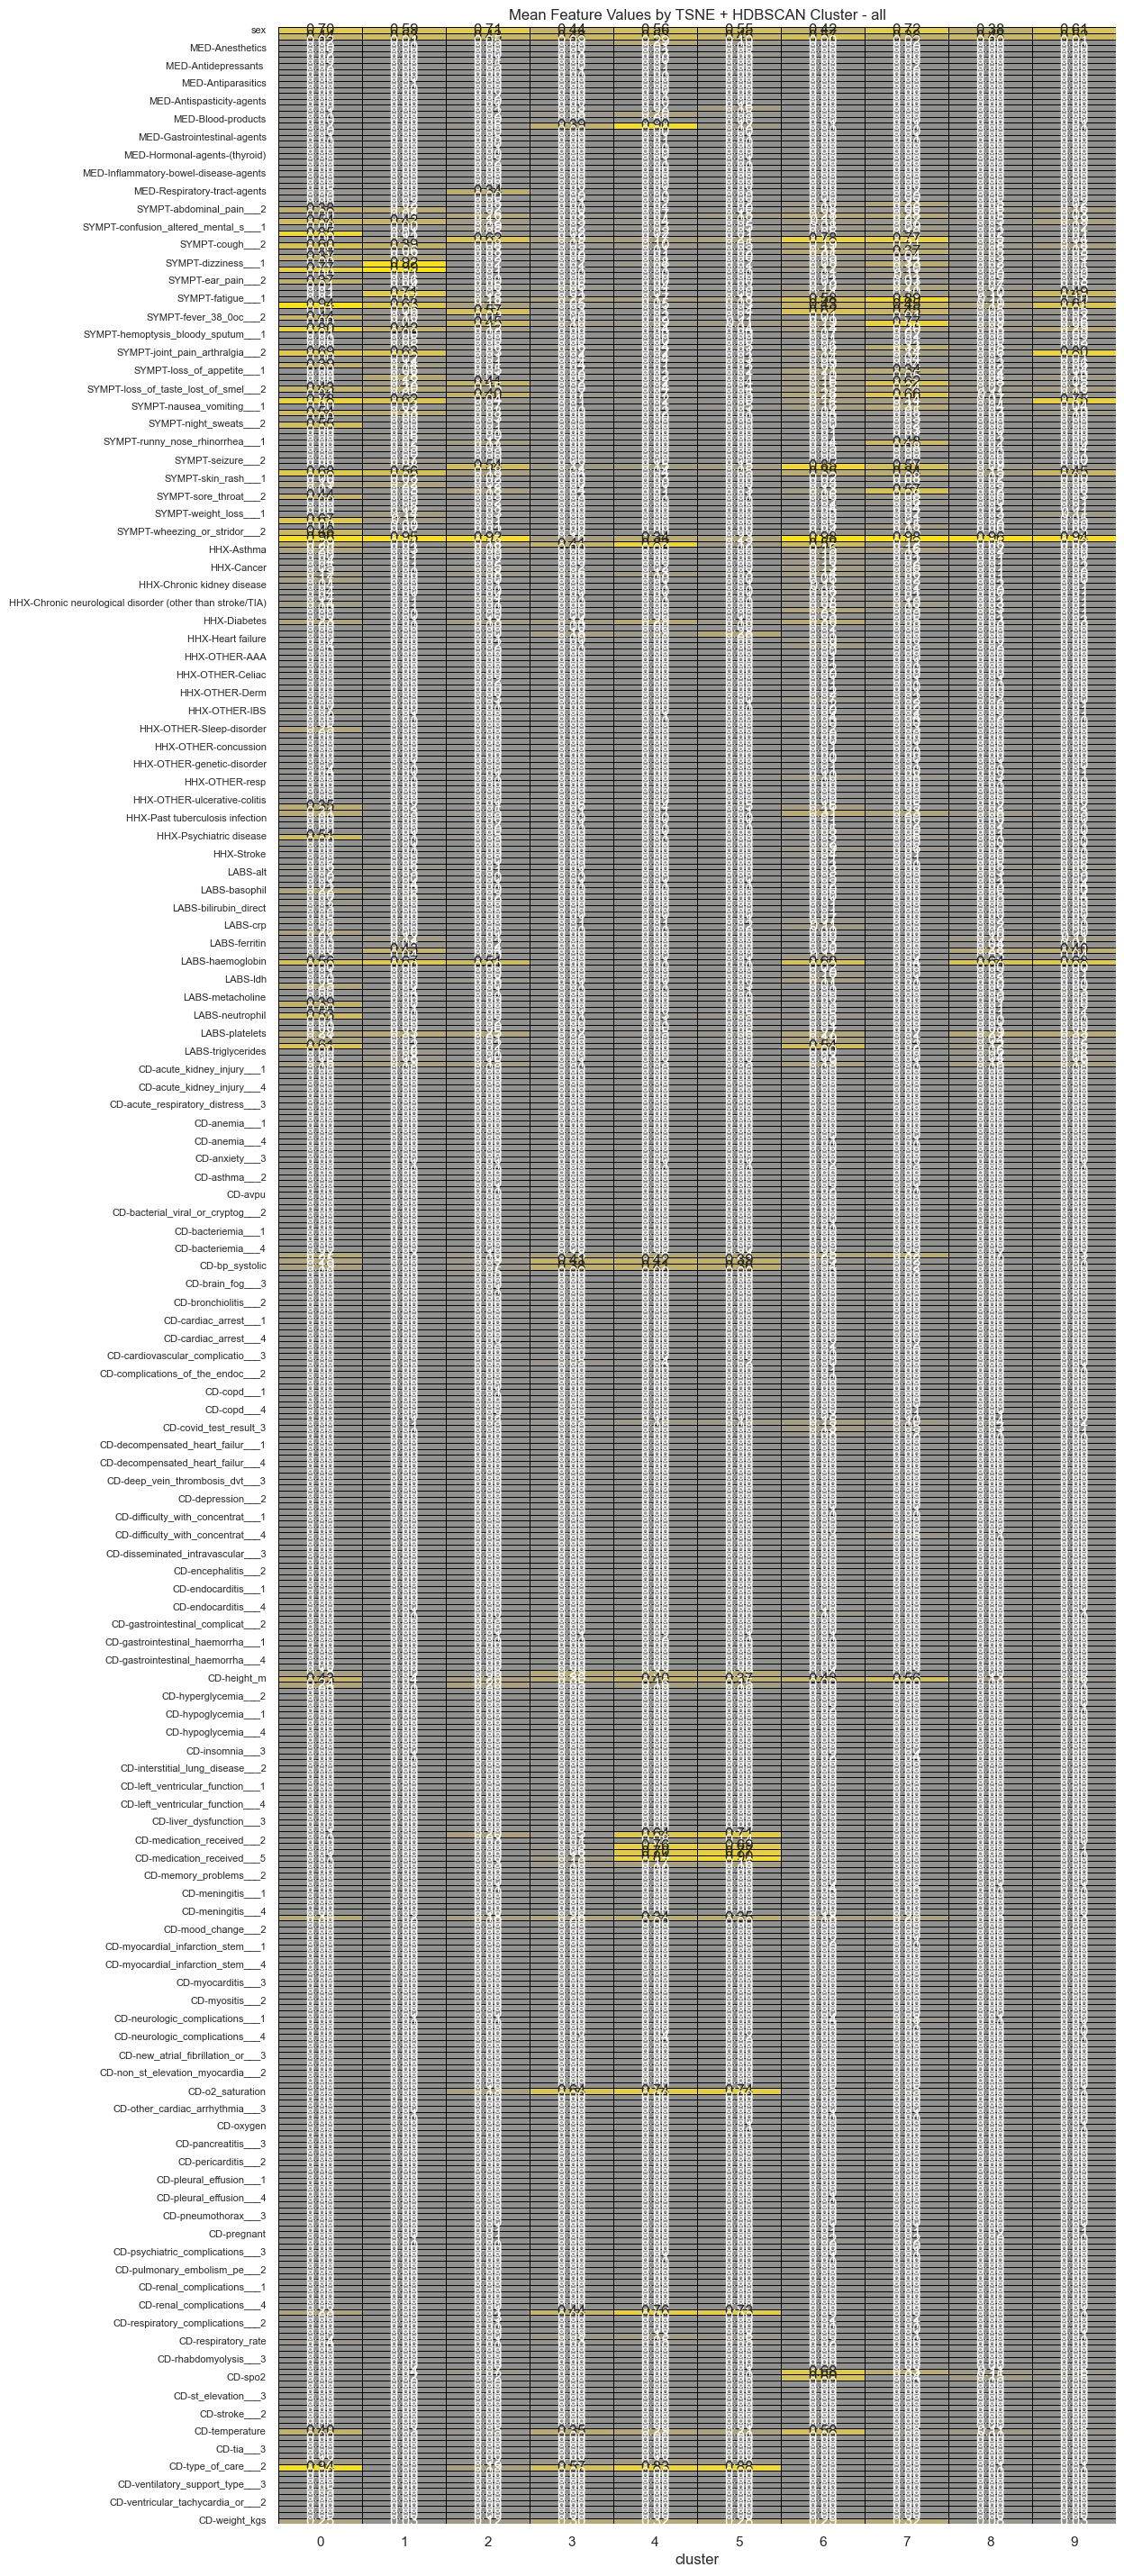

In [861]:
# heatmap of the means by cluster
fig, ax = plt.subplots(figsize=(12,36))

# apply lognorm to the colour scale
norm = mc.LogNorm(vmin = 0.01, vmax = 10.0)
norm = None

# get the means by cluster

# augment with cluster
XX["cluster"] = tsne_df["Most Likely Cluster"]

mm = XX.groupby("cluster").mean().T

# negative log transform
# mm = -np.log10(mm)

# sort mm in alphabetical order
# mm = mm.sort_index()

# use a diverging colour scheme
cmap = sns.diverging_palette(220, 20, as_cmap = True)

cmap = cc.cm.bjy

sns.heatmap(mm, ax = ax, cmap = cmap,norm = norm, **heatmap_parms)

plt.title(f"Mean Feature Values by TSNE + HDBSCAN Cluster - {tag}")
# make font smaller
plt.yticks(fontsize = 8);
# plt.savefig('mean_feature_values.png', dpi = 300)

fn = f"mean-feature-values-tsne-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')


# TODO

- "feature importances" - what features discriminate between the clusters?

## SUBGROUP: Lusaka

In [862]:
# make a df just for Lusaka
df_lusaka = LC_pos.query('dag == 5')

df_lusaka.info()

<class 'pandas.core.frame.DataFrame'>
Index: 549 entries, 3709 to 5146
Columns: 421 entries, sex to cluster
dtypes: float64(367), int64(53), object(1)
memory usage: 1.8+ MB


In [863]:

# drop object columns
# drop columns with dtype = object
try:
    df_lusaka = df_lusaka.drop(columns=['LC_STATUS'])

except:
    pass


df_lusaka = df_lusaka.drop(columns = df_lusaka.filter(regex = 'LABS').columns)
df_lusaka = df_lusaka.drop(columns = df_lusaka.filter(regex = 'CD').columns)
df_lusaka = df_lusaka.drop(columns = df_lusaka.filter(regex = 'MED').columns)
df_lusaka = df_lusaka.drop(columns = df_lusaka.filter(regex = 'SYMPT').columns)



df_lusaka.info()


<class 'pandas.core.frame.DataFrame'>
Index: 549 entries, 3709 to 5146
Data columns (total 60 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   sex                                                        544 non-null    float64
 1   age                                                        543 non-null    float64
 2   dag                                                        549 non-null    int64  
 3   VAX-vaccinated                                             131 non-null    float64
 4   HHX-Arterial Hypertension                                  549 non-null    float64
 5   HHX-Asthma                                                 4 non-null      float64
 6   HHX-Atrial fibrillation or flutter                         3 non-null      float64
 7   HHX-COPD (emphysema                                        3 non-null      float64
 8   HHX-Cancer 

In [864]:
# fill nas with zero
df_lusaka.fillna(0, inplace = True)

# drop SITE and dag
df_lusaka = df_lusaka.drop(columns = ['SITE', 'dag'])

In [869]:
# use tsne and hdbscan to reduce and cluster
# instantiate the clustering and dim reduction objects

# always use the reference data for clustering
X = deepcopy(df_lusaka)

# scale the data
X = scaler.fit_transform(X)


# X.dropna(inplace= True)
# X.fillna(0)

# dimension reduction
tsne_embeddings = tsne.fit_transform(X)

# clustering on the reduced data
hdb_tsne.fit(tsne_embeddings)

# get the cluster vectors

cvec = all_points_membership_vectors(hdb_tsne)

# cluster labels are the maximally probable cluster
cluster_labels = np.argmax(cvec, axis = 1)

print(f"Found {len(np.unique(cluster_labels))} clusters")


Found 5 clusters


In [870]:
# make a df for plotting
# sites = df_lusaka["dag"].map(site_name_dict)

plot_df = make_plot_df(tsne_embeddings, hdb_tsne, X.index, sites)

In [871]:
plot_df

,x,y,Cluster,Cluster Confidence,Most Likely Cluster,Site
3709,25.812918,-12.124918,4,1.000000,4,LUS
3710,6.259690,-6.624129,4,0.843625,3,LUS
3711,21.651384,-3.416126,4,0.952307,4,LUS
3712,-14.321727,-14.379405,2,1.000000,2,LUS
3714,-2.773917,7.811151,0,0.656677,0,LUS
...,...,...,...,...,...,...
5130,-28.537794,3.857892,1,1.000000,1,LUS
5133,-30.309200,1.928380,1,1.000000,1,LUS
5136,-4.881819,20.728996,0,1.000000,0,LUS
5138,-18.234514,-6.103036,1,0.228684,2,LUS


<Axes: xlabel='x', ylabel='y'>

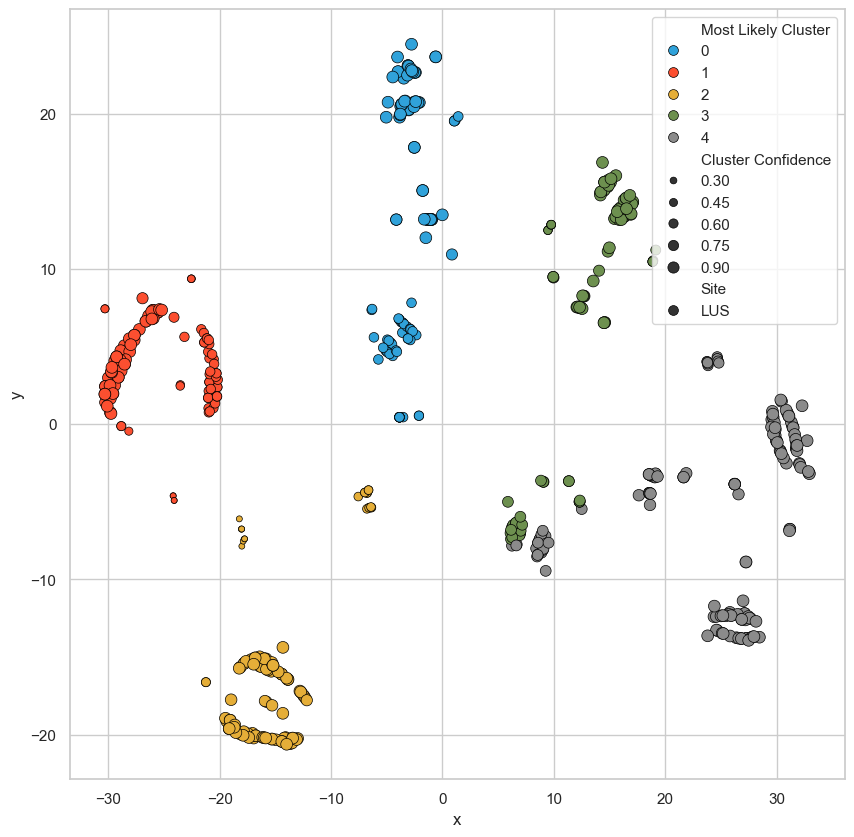

In [872]:
# plot the plot_df
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(data = plot_df,
                x = "x",
                y = "y",
                s = 50,
                edgecolor = 'black', 
                hue       = "Most Likely Cluster",
                linewidth = 0.5, 
                palette   = palette_dict,
                style     = "Site",
                size      = "Cluster Confidence",
                ax = ax
                    )